In [12]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
path="C:/Users/STEVE/Desktop/Fuel consumption project/fuel consumption datat/notebook_data"
dc=pd.read_csv(path+"/test0.csv")
trk1=pd.read_csv(path+"/trk1.csv")
trk1_2t=pd.read_csv(path+"/1_truck_double_trailer_65mph.csv")
dc.columns

Index(['t', 'mode', 'pl_pos', 'brk_sw', 'yaw_ang', 'sp', 'lat_acc', 'lon_acc',
       'yaw_rt', 'fuel_CANbus', 'steer_ang', 'weight', 'cacc_tgap', 'my_var',
       'STP', 'opt_m', 'MOVES_rates', 'MOVES_gr', 'MOVES_gl', 'E_gl', 'E_gr',
       '%E'],
      dtype='object')

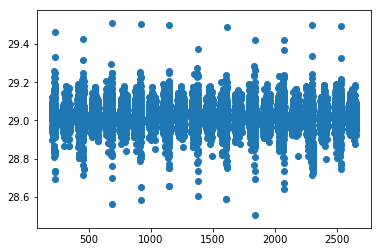

In [14]:
fig, ax=plt.subplots(1,1)
aut=trk1[(trk1.t>200) & (trk1.t<3700) & (trk1.yaw_rt<0.02)]
ax.scatter(aut.t,aut.sp)
ax.set_ylim=(0,30)

plt.show()
#aut.to_csv("C:/Users/STEVE/Desktop/Autonomie/const_aquiz.csv")

In [15]:
dc2=pd.read_csv("C:/Users/STEVE/Test_truck_data/dcj.csv")
trk12=pd.read_csv("C:/Users/STEVE/Test_truck_data/trk1j.csv")
trk1_2t2=pd.read_csv("C:/Users/STEVE/Test_truck_data/trk1_2tj.csv")

In [16]:
dc3=pd.concat([dc,dc2.jerk_index], axis=1)
trk13=pd.concat([trk1,trk12.jerk_index], axis=1)
trk1_2t3=pd.concat([trk1_2t,trk1_2t2.jerk_index], axis=1)

In [17]:
#############extract trk1
df1=trk13
trk1_const=df1[(df1.yaw_rt<0.02) & (400<=df1.t) & (df1.t<=500)]
trk1_acc=df1[(df1.yaw_rt<0.02) & (91.5<=df1.t) & (df1.t<=120)]
df_trk1=pd.concat([trk1_const,trk1_acc], axis=0)

#############extract trk1_2t
df1=trk1_2t3
trk1_2t_const=df1[(df1.yaw_rt<0.02) & (500<=df1.t) & (df1.t<=620)]
trk1_2t_acc=df1[(df1.yaw_rt<0.02) & (219<=df1.t) & (df1.t<=250)]
df_trk1_2t=pd.concat([trk1_2t_const,trk1_2t_acc], axis=0)
##########extract dc
df1=dc3
df_dc=dc3[(dc3.t>790) & (dc3.t<2180)]

In [18]:
path_out="C:/Users/STEVE/Desktop/Autonomie"
df_trk1.to_csv(path_out+"/trk1.csv")

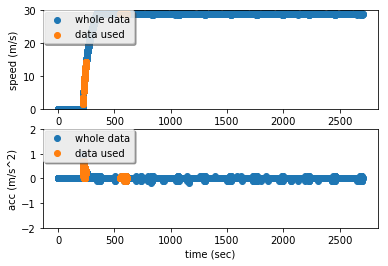

In [19]:

def plot_data(df,df_):
    fig, (ax1, ax2)=plt.subplots(2,1)
    line11=ax1.scatter(df.t,df['sp'], label='whole data')
    line12=ax1.scatter(df_.t,df_['sp'], label='data used')
    line21=ax2.scatter(df.t,df['lon_acc'], label='whole data')
    line22=ax2.scatter(df_.t,df_['lon_acc'],label='data used')
    ax1.set_ylabel('speed (m/s)')
    ax1.set_xlabel('time (sec)')
    ax2.set_ylabel('acc (m/s^2)')
    ax2.set_xlabel('time (sec)')
    ax1.set_ylim(0,30)
    ax2.set_ylim(-2,2)
    
    legend1 = ax1.legend(loc='upper left', shadow=True,borderaxespad=0.)
    legend2 = ax2.legend(loc='upper left', shadow=True,borderaxespad=0.)
        

    plt.show()
    
plot_data(trk1_2t, df_trk1_2t)


In [20]:
dc_agg_c=df_dc[['opt_m','jerk_index','fuel_CANbus','MOVES_gr']].groupby(["opt_m","jerk_index"]).count()
trk1_agg_c=df_trk1[['opt_m','jerk_index','fuel_CANbus','MOVES_gr']].groupby(["opt_m","jerk_index"]).count()
trk1_2t_agg_c=df_trk1_2t[['opt_m','jerk_index','fuel_CANbus','MOVES_gr']].groupby(["opt_m","jerk_index"]).count()

In [21]:
path_out='C:/Users/STEVE/Test_truck_data/aggdata/'
dc_agg_c.to_csv(path_out+'dc_agg_c.csv')
trk1_agg_c.to_csv(path_out+'trk1_agg_c.csv')
trk1_2t_agg_c.to_csv(path_out+'trk1_2t_agg_c.csv')

In [22]:
dc_agg=df_dc[['opt_m','jerk_index','fuel_CANbus','MOVES_gr']].groupby(["opt_m","jerk_index"]).mean()
trk1_agg=df_trk1[['opt_m','jerk_index','fuel_CANbus','MOVES_gr']].groupby(["opt_m","jerk_index"]).mean()
trk1_2t_agg=df_trk1_2t[['opt_m','jerk_index','fuel_CANbus','MOVES_gr']].groupby(["opt_m","jerk_index"]).mean()
dc_agg.to_csv(path_out+'dc_agg.csv')
trk1_agg.to_csv(path_out+'trk1_agg.csv')
trk1_2t_agg.to_csv(path_out+'trk1_2t_agg.csv')